### 模擬器執行

引用函式庫

In [1]:
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

畫圖

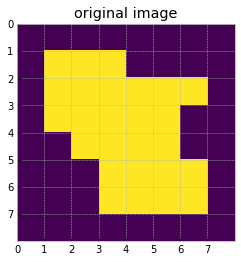

In [2]:
img = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

plot_image(img, 'original image')

轉換成量子疊加態表示

In [3]:
def amplitude_encode(img_data):
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    norm_image = []
    for arr in img_data:
        for ele in arr:
            norm_image.append(ele / rms)

    return np.array(norm_image)

image_norm_h = amplitude_encode(img)
image_norm_v = amplitude_encode(img.T)


環境變數設定

In [11]:
data_qb = 6 # log2(8 * 8)
anc_qb = 1
total_qb = data_qb + anc_qb

D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

建立量子電路

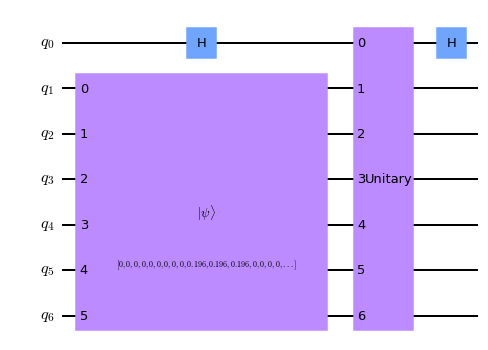

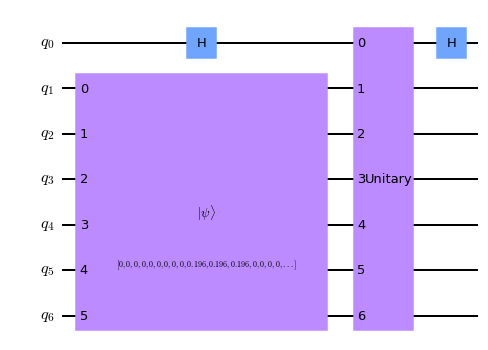

In [12]:
# 水平的
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# 垂直的
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

circ_list = [qc_h, qc_v]

建立模擬器

In [13]:
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print("Horizontal:")
display(array_to_latex(sv_h[:30], max_size=30))
print()
print("Vertical:")
display(array_to_latex(sv_v[:30], max_size=30))

Horizontal:


<IPython.core.display.Latex object>


Vertical:


<IPython.core.display.Latex object>

後處理

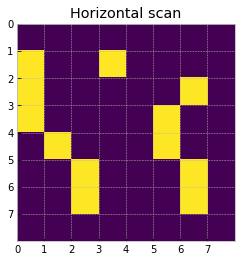

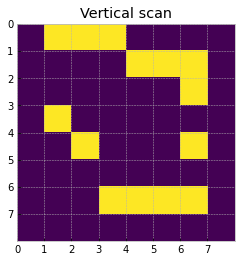

In [14]:
def threshold(amp):
    return amp > 1e-15 or amp < -1e-15

edge_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

plot_image(edge_h, 'Horizontal scan')
plot_image(edge_v, 'Vertical scan')

結合

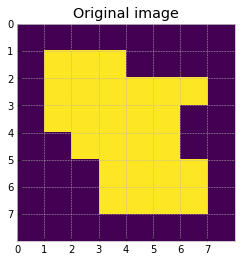

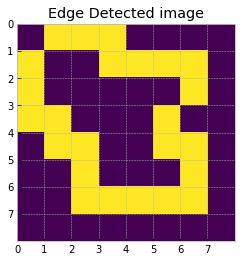

In [15]:
edge = edge_h | edge_v

plot_image(img, 'Original image')
plot_image(edge, 'Edge Detected image')

### 大圖如何處理?
須將大圖換成多個小圖，再依序組合起來

原因：量子數有限，不可能將太大張的圖整張放進來處理

1. 載入圖片

Raw Image info: (256, 256, 3)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


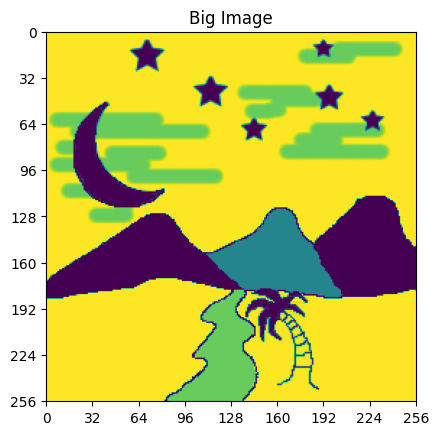

In [9]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('edge_detection_input.jpg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

2. 切割

In [11]:
image_crop_size = 32   # Width of each part of image for processing

parts = int(image_size / image_crop_size)
cropped_img = [[0 for _ in range(parts)] for _ in range(parts)]
for i in range(parts):
    for j in range(parts):
        cropped_img[i][j] = image[i*image_crop_size:(i+1)*image_crop_size, j*image_crop_size:(j+1)*image_crop_size]

In [12]:
data_qb = 10 # log2(8 * 8)
anc_qb = 1
total_qb = data_qb + anc_qb

D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [25]:
result = [[0 for _ in range(parts)] for _ in range(parts)]
back = Aer.get_backend('statevector_simulator')

for i in range(parts):
    for j in range(parts):
        print(f"part ({i}, {j})")

        image_norm_h = amplitude_encode(cropped_img[i][j])
        image_norm_v = amplitude_encode(cropped_img[i][j].T)

        # 水平的
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)

        # 垂直的
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)

        circ_list = [qc_h, qc_v]
                
        
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)

        edge_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image_crop_size, image_crop_size)
        edge_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image_crop_size, image_crop_size).T

        edge = edge_h | edge_v

        result[i][j] = edge

part (0, 0)
part (0, 1)
part (0, 2)
part (0, 3)
part (1, 0)
part (1, 1)
part (1, 2)
part (1, 3)
part (2, 0)
part (2, 1)
part (2, 2)
part (2, 3)
part (3, 0)
part (3, 1)
part (3, 2)
part (3, 3)


In [26]:
result_np = np.ndarray((256, 256))
for i in range(parts):
    for j in range(parts):
        result_np[i*image_crop_size:(i+1)*image_crop_size, j*image_crop_size:(j+1)*image_crop_size] = result[i][j]

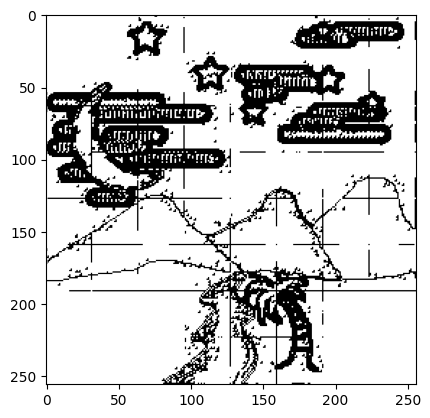

In [23]:
style.use('default')
plt.imshow(result_np, cmap='Greys')
plt.show()

範例二

Raw Image info: (128, 128, 3)
Raw Image datatype: uint8
Image shape (numpy array): (128, 128)


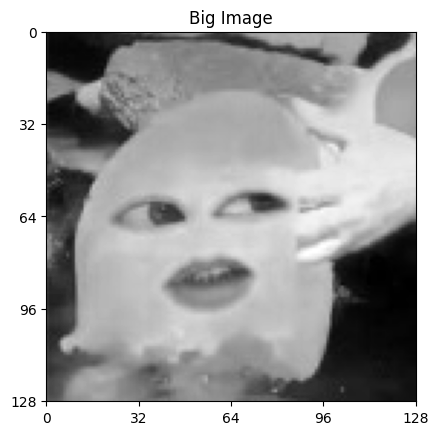

In [14]:
from PIL import Image

image_size = 128       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('guigangai.jpg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='gray')
plt.show()

In [15]:
image_crop_size = 32   # Width of each part of image for processing

parts = int(image_size / image_crop_size)
cropped_img = [[0 for _ in range(parts)] for _ in range(parts)]
for i in range(parts):
    for j in range(parts):
        cropped_img[i][j] = image[i*image_crop_size:(i+1)*image_crop_size, j*image_crop_size:(j+1)*image_crop_size]

In [16]:
data_qb = 10 # log2(8 * 8)
anc_qb = 1
total_qb = data_qb + anc_qb

D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [17]:
result = [[0 for _ in range(parts)] for _ in range(parts)]
back = Aer.get_backend('statevector_simulator')

for i in range(parts):
    for j in range(parts):
        print(f"part ({i}, {j})")

        image_norm_h = amplitude_encode(cropped_img[i][j])
        image_norm_v = amplitude_encode(cropped_img[i][j].T)

        

        # 水平的
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)

        # 垂直的
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)

        circ_list = [qc_h, qc_v]
                
        
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)

        edge_h = np.abs(np.array([sv_h[2*i+1].real for i in range(2**data_qb)])).reshape(image_crop_size, image_crop_size)
        edge_v = np.abs(np.array([sv_v[2*i+1].real for i in range(2**data_qb)])).reshape(image_crop_size, image_crop_size).T

        edge = edge_h + edge_v

        result[i][j] = edge

part (0, 0)
part (0, 1)
part (0, 2)
part (0, 3)
part (1, 0)
part (1, 1)
part (1, 2)
part (1, 3)
part (2, 0)
part (2, 1)
part (2, 2)
part (2, 3)
part (3, 0)
part (3, 1)
part (3, 2)
part (3, 3)


In [18]:
result_np = np.ndarray((128, 128))
for i in range(parts):
    for j in range(parts):
        result_np[i*image_crop_size:(i+1)*image_crop_size, j*image_crop_size:(j+1)*image_crop_size] = result[i][j]

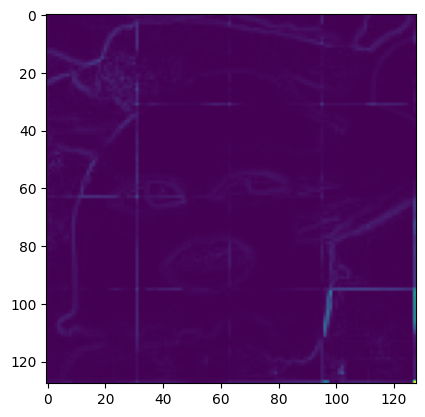

In [19]:
style.use('default')
plt.imshow(result_np)
plt.show()